(example-mzi)=
# Mach-Zehnder interferometer

In this tutorial, we'll define and simulate a simple circuit known as a
Mach-Zender Interferometer (MZI). It assumes you've read the previous tutorial, 
[intro](./intro).

Simphony uses [SAX](https://flaport.github.io/sax/index.html) to define 
models and simulate circuits, which uses 
[JAX](https://jax.readthedocs.io/en/latest/index.html) as a computational 
engine. JAX can provide a nice speedup for larger circuits if their models are 
appropriately defined and you have a GPU. Otherwise, it will run perfectly fine 
on a CPU.

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sax

In [2]:
from simphony.libraries import siepic

Models in SAX (and therefore in Simphony) are simply "callables" 
(functions) that return a dictionary of scattering parameters. The keys of that
resulting dictionary are the port-to-port relationships, in the form ``(output, input)``
by convention, just as the column ordering of a regular s-parameter matrix.

Models in SAX must have default parameters in their function signatures; that 
is, no positional arguments are allowed. This means that they can always be 
called to inspect what their return values are (or what port names are provided).

In [3]:
siepic.grating_coupler?

Signature:
siepic.grating_coupler(
    wl: Union[float, jax.Array] = 1.55,
    pol: Literal['te', 'tm'] = 'te',
    thickness: float = 220.0,
    dwidth: float = 0,
) -> Dict[Tuple[str, str], jaxtyping.Complex[Array, '...']]
Docstring:
SiEPIC EBeam PDK grating coupler optimized for TE polarizations at
1550nm.

The grating coupler efficiently couples light from a fiber array positioned
above the chip into the circuit. For the TE mode, the angle is -25 degrees
[needs citation].

.. image:: /_static/images/ebeam_gc_te1550.png
    :alt: ebeam_bdc_te1550.png

Parameters
----------
wl : float or Array
    The wavelengths to evaluate at in microns.
pol : {"te", "tm"}
    Polarization of the input/output modes.
thickness : {210.0, 220.0, 230.0}
    Thickness of the grating coupler silicon in nm. Useful for simulating
    manufacturing variability.
dwidth : {-20.0, 0.0, 20.0}
    Change in width from nominal of the gratings. Representative of
    manufacturing variability. Must be one of -20, 0

By convention, the ``"wl"`` argument is in microns. This is not enforced, and
various model libraries may follow different convention, so it's always good to
double check the documentation of the model you're using (or create documentation
for it, if you're writing the model)!

In [4]:
siepic.grating_coupler()

{('o0', 'o0'): Array([-0.0307378-0.00345908j], dtype=complex128),
 ('o0', 'o1'): Array([0.75686856+0.02082852j], dtype=complex128),
 ('o1', 'o0'): Array([0.74360676+0.09760613j], dtype=complex128),
 ('o1', 'o1'): Array([0.0750638-0.02585451j], dtype=complex128)}

A SAX circuit contains a 
netlist, which is a collection of component instances, their connections, and 
exposed ports; and a list of models, which makes it easy to swap out different
models without rewriting your netlist to see how the circuit behavior
changes.

The netlist is a dictionary with three fields:

* ``"instances"``: A dictionary of instance names to human-readable component 
    model strings (like "coupler" or "waveguide"). You will define the 
    string-to-model mapping later.
* ``"connections"``: A dictionary of ports to ports in the form 
    ``"instance_name,port_name": "instance_name,port_name"`` (note there is no
    whitespace delimiting the instance from its port, just a comma).
* ``"ports"``: Since a SAX circuit is basically a model itself, and could be
    used in other circuits, it has exposed ports. This field is a dictionary 
    mapping port names of the composite object to the ports of its constituent
    instances.

In [5]:
mzi, info = sax.circuit(
    netlist={
        "instances": {
            "gc_in": "gc",
            "left": "ybranch",
            "top": "waveguide",
            "bottom": "waveguide",
            "right": "ybranch",
            "gc_out": "gc",
        },
        "connections": {
            "gc_in,o0": "left,o0",
            "left,o1": "top,o0",
            "left,o2": "bottom,o0",
            "top,o1": "right,o1",
            "bottom,o1": "right,o2",
            "right,o0": "gc_out,o0",
        },
        "ports": {
            "in": "gc_in,o1",
            "out": "gc_out,o1",
        },
    },
    models={
        "ybranch": siepic.y_branch,
        "waveguide": siepic.waveguide,
        "gc": siepic.grating_coupler,
    }
)

``sax.circuit`` returns a tuple. The first element is another callable function. All
parameters you call it with will be passed on to the models contained within the
circuit, so long as they are named the same. In this way, a circuit itself can 
act as a model within another circuit.

```{warning}
It is important that your all models have common names for arguments. For example,
models that take a ``length`` parameter should all be named ``length``. Models
that are wavelength dependent should all take the same ``wl`` parameter (by 
convention). If you have your own model library, you can follow whatever 
convention you want, as long as it's consistent.
```

The second element of the tuple is a information object that contains details
about the circuit.

We can simulate the circuit by simply calling it with the wavelengths we want to
simulate at.

The circuit itself contains parameterized models. We can pass arguments targeting
those models by passing a dictionary of keyword arguments and corresponding values
when invoking the circuit function. The names you gave the instances
in the netlist become the keyword arguments of the function. You can pass a 
dictionary which will be used to instantiate those components at simulation time.

In this case, we want to make the ``"top"`` and ``"bottom"`` waveguides 
different lengths. The waveguide model takes a "length" argument, so that's
what we'll use in our dictionary of parameters.

In [6]:
wl = jnp.linspace(1.5, 1.6, 1000)
S = mzi(wl=wl, top={"length": 150.0}, bottom={"length": 50.0})

We're interested in the magnitude squared of the transmission from the input
to the output, so we'll square the magnitude of the ``"out,in"`` element of the
resulting dictionary. Recall, too, that we renamed these ports in the netlist
when we created the circuit. It's really easy to give the ports on your 
composite circuits meaningful names, and it makes your code much more readable.

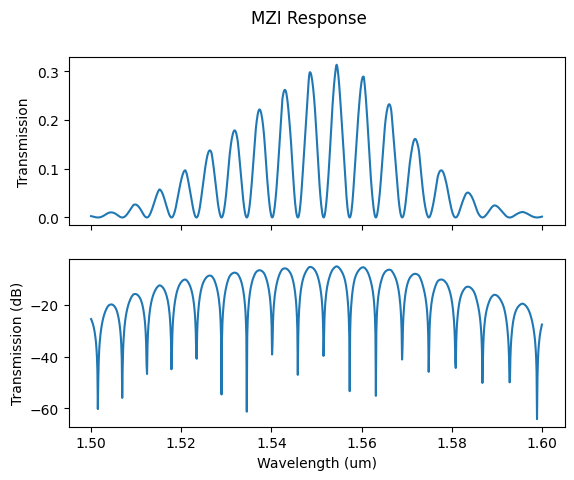

In [7]:
mag = jnp.abs(S["out", "in"])**2

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(wl, mag)
axs[0].set_ylabel("Transmission")
axs[1].plot(wl, 10*jnp.log10(mag))
axs[1].set_ylabel("Transmission (dB)")
axs[1].set_xlabel("Wavelength (um)")
plt.suptitle("MZI Response")
plt.show()

## Sweep simulation

Simphony also provides some handy classes for running simulations and doing
further analysis on the results. We'll use the ``ClassicalSim`` class to run
a sweep simulation. This class takes a circuit and a list of wavelengths to
simulate at. Additionally, we'll add an ideal laser to the input and wavelength
independent photodetectors to our output.

In [8]:
from simphony.simulation import ClassicalSim

wl = jnp.linspace(1.5, 1.6, 1000)

sim = ClassicalSim(ckt=mzi, wl=wl, top={"length": 150.0}, bottom={"length": 50.0})
laser = sim.add_laser(ports=["in"], power=1.0)
detector = sim.add_detector(ports=["out"])

Now we simulate.

In [9]:
result = sim.run()

The list of detectors in the simulation result have some handy functions for plotting the data. Or, you can access the data directly from its ``.wl`` and ``.power`` attributes.

<Axes: xlabel='Wavelength (um)', ylabel='Power (mW)'>

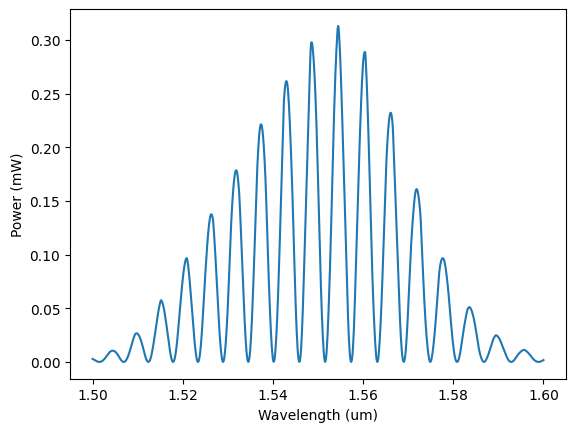

In [10]:
result.detectors["out"].plot()

You can also access the underlying s-parameters directly. Here we use [``matplotlib``](https://matplotlib.org/) to plot the magnitude squared of scattering parameters of the MZI. Note that once an input signal has been applied, the ``sdict`` only contains the outputs as keys, instead of an input-output tuple for each relationship.

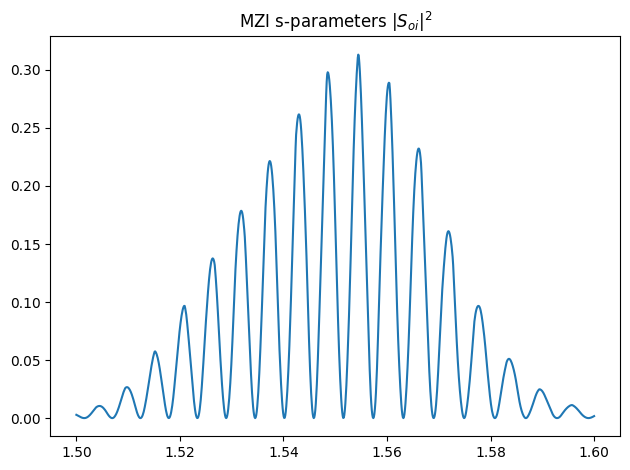

In [11]:
wl = result.wl
s = result.sdict["out"]

plt.plot(wl, jnp.abs(s)**2)
plt.title(r"MZI s-parameters $|S_{oi}|^2$")
plt.tight_layout()
plt.show()